In [1]:
#!pip install pyod            # normal install
#!pip install --upgrade pyod  # or update if needed

# 1. Importación de librerías necesarias

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score, classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Para detección de outliers
from pyod.models.knn import KNN

from scipy.stats import norm

# 2. Carga del conjunto de datos

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from google.colab import files
uploaded = files.upload()

In [5]:
path = '/content/drive/MyDrive/Skin_Segmentation/dataset.csv'
df = pd.read_csv(path)

# 3. Análisis exploratorio de datos (EDA)

In [6]:
df.head(1000)

,B,G,R,Y
0,74,85,123,1
1,73,84,122,1
2,72,83,121,1
3,70,81,119,1
4,70,81,119,1
...,...,...,...,...
995,210,216,253,1
996,210,216,251,1
997,210,216,251,1
998,209,218,252,1


## a) Número de muestras, datos faltantes, atributos y tipos de variables de cada atributo

In [7]:
print(f'Número de muestras: {df.shape[0]}')
print(f'Número de atributos: {df.shape[1]}')
df.shape

Número de muestras: 245057
Número de atributos: 4


(245057, 4)

In [8]:
print("Datos Faltantes por atributo")
df.isnull().sum()

Datos Faltantes por atributo


,0
B,0
G,0
R,0
Y,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245057 entries, 0 to 245056
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   B       245057 non-null  int64
 1   G       245057 non-null  int64
 2   R       245057 non-null  int64
 3   Y       245057 non-null  int64
dtypes: int64(4)
memory usage: 7.5 MB


## b) Medidas de centralidad y dispersión


In [10]:
# Para atributos numéricos
df.describe()

,B,G,R,Y
count,245057.000000,245057.000000,245057.000000,245057.000000
mean,125.065446,132.507327,123.177151,1.792461
std,62.255653,59.941197,72.562165,0.405546
min,0.000000,0.000000,0.000000,1.000000
25%,68.000000,87.000000,70.000000,2.000000
50%,139.000000,153.000000,128.000000,2.000000
75%,176.000000,177.000000,164.000000,2.000000
max,255.000000,255.000000,255.000000,2.000000


## c) Visualizaciones

### Boxplots (diagramas de cajas y bigotes) para cada variable numérica

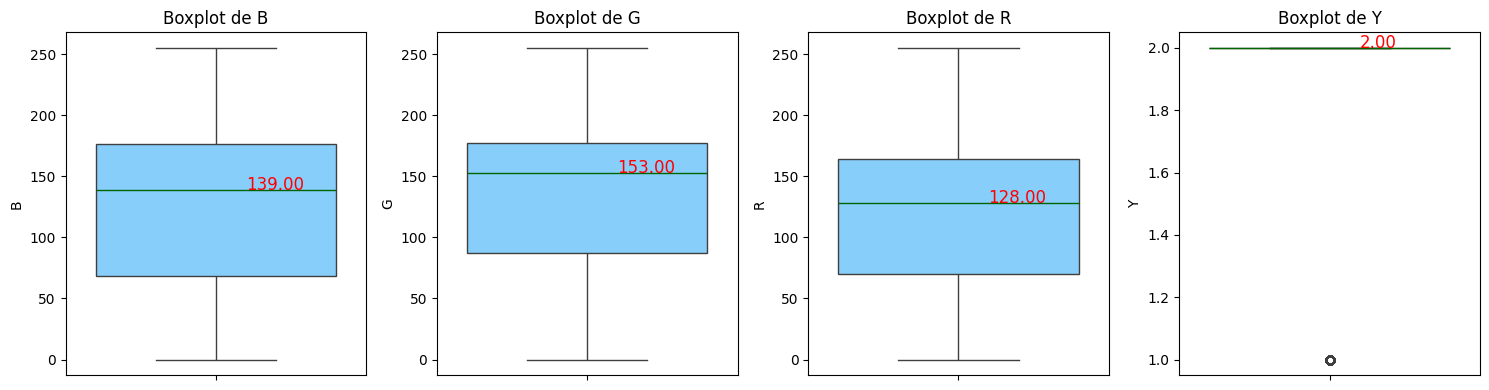

In [11]:
plt.figure(figsize=(15,4))
for i, col in enumerate(['B', 'G', 'R', 'Y']):
    plt.subplot(1, 4, i + 1)

    bp = sns.boxplot(y=df[col], medianprops={'color': 'darkgreen'},
                     patch_artist=True,
                     boxprops={'facecolor': 'lightskyblue'})

    median_val = df[col].median()
    plt.text(0.1, median_val, f'{median_val:.2f}',
             fontsize=12, color='red')

    plt.title(f'Boxplot de {col}')
plt.tight_layout()
plt.show()

### Análisis de los Diagramas de Caja y Datos Estadísticos

#### Interpretación General

* **Variables B, G y R:**
    * **Distribución similar:** Presentan distribuciones relativamente simétricas, indicando una variabilidad similar en los datos.
    * **Rangos amplios:** Sugieren una amplia gama de valores.
    * **Medianas cercanas**: Indican que los valores centrales son comparables.
* **Variable Y:**
    * **Distribución sesgada**: Mayoría de los valores concentrados en 2.0.
    * **Rango estrecho:** Poca variabilidad.

#### Posibles Implicaciones

Las características observadas pueden tener diferentes implicaciones dependiendo del contexto:

* **Variables B, G y R:** Podrían representar canales de color en imágenes, sugiriendo una distribución equilibrada de colores.
* **Variable Y:** Podría representar una característica binaria (si un píxel pertenece a una región de interés).

### Histograma para cada atributo numérico

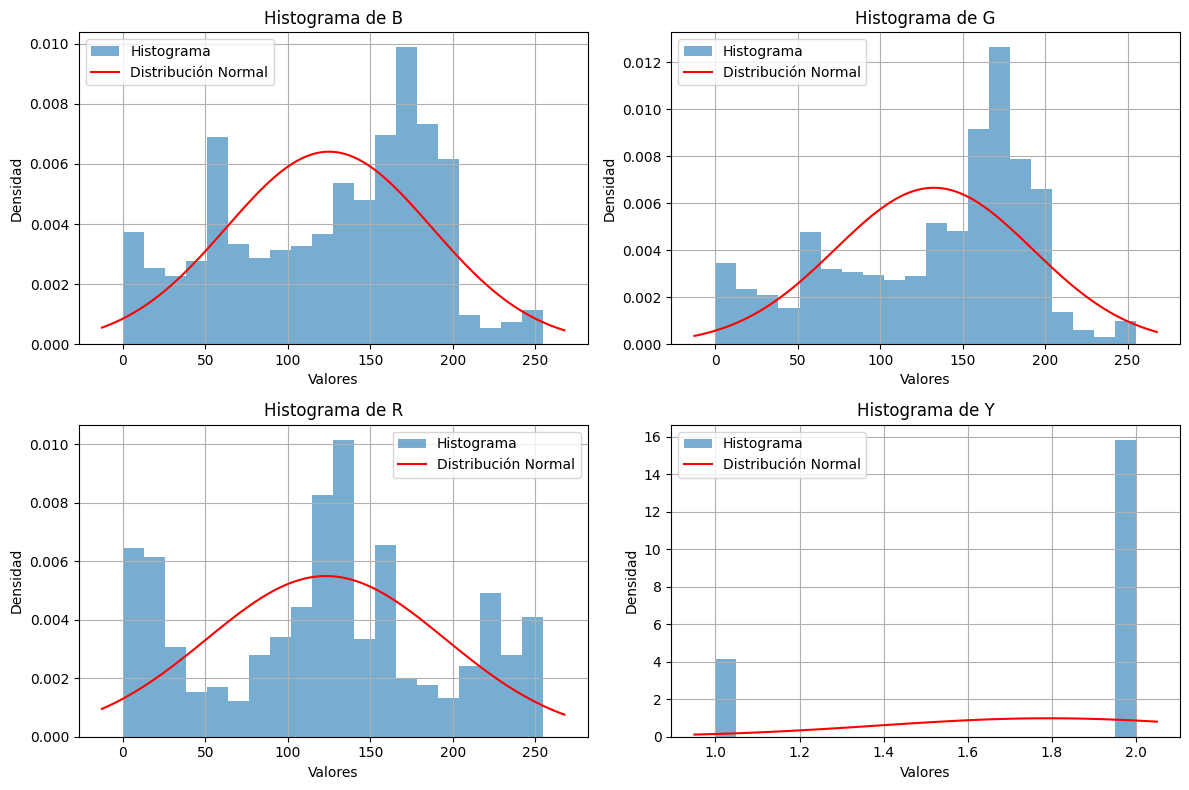

In [12]:

def graficarHistogramaDistNormal(column, title, subplot):
    plt.subplot(subplot)
    plt.hist(df[column], bins=20, density=True, alpha=0.6, label='Histograma')

    # Calcular la media y desviación estándar
    mu, std = norm.fit(df[column])

    # Generar valores para la distribución normal teórica
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    y = norm.pdf(x, mu, std)

    plt.plot(x, y, 'r-', label='Distribución Normal')

    plt.xlabel('Valores')
    plt.ylabel('Densidad')
    plt.title(title)
    plt.legend()
    plt.grid(True)

# Crear una figura de 2x2 subplots
plt.figure(figsize=(12, 8))

# Llamar a la función para cada columna en un subplot diferente
graficarHistogramaDistNormal('B', 'Histograma de B', 221)  # Fila 2, columna 1
graficarHistogramaDistNormal('G', 'Histograma de G', 222)  # Fila 2, columna 2
graficarHistogramaDistNormal('R', 'Histograma de R', 223)  # Fila 2, columna 3
graficarHistogramaDistNormal('Y', 'Histograma de Y', 224)  # Fila 2, columna 4

plt.tight_layout()
plt.show()

Aunque al aplicar una regresión logística no es indispensable normalizar o escalar las características, es recomendable examinar sus distribuciones. Al analizar los gráficos resultantes, observamos que las características presentan una distribución aproximadamente normal, lo cual, aunque no es obligatorio para la regresión logística, facilita el manejo de los datos y es un aspecto a considerar al interpretar los resultados.

### Observaciones:

- **B, G y R:** Presentan una distribución aproximadamente normal, con una curva de densidad que se ajusta razonablemente bien a los datos, sugiriendo una dispersión aleatoria alrededor de un valor central.

- **Y:** Muestra una fuerte asimetría a la izquierda, con la mayoría de los valores concentrados en el extremo superior, indicando una distribución sesgada donde la distribución normal no es un buen ajuste.

Sin embargo, como mencionamos previamente, ***Y*** podría representar una característica binaria y realmente si lo es, basándonos en la documentación del repositorio del data set podemos apreciar la siguiente tabla:

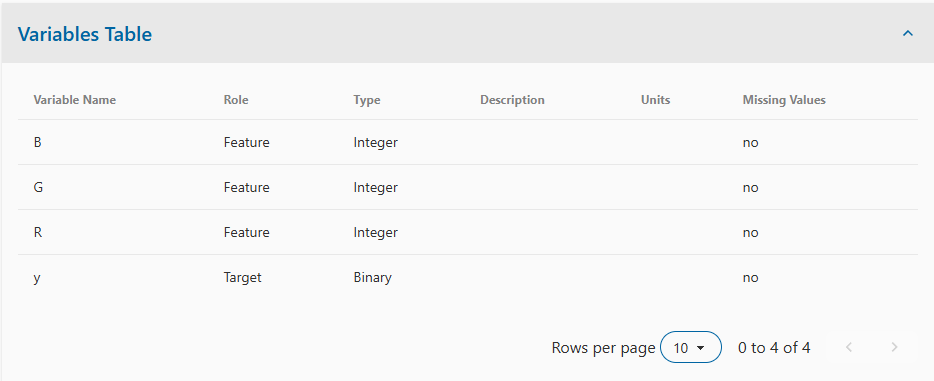

Basándonos en la ***Tabla de Variables*** anterior, podemos ver que nuestra variable de destino (***Y***) es binaria, pero que está compuesta de 1 y 2.

La mejor práctica es que nuestra variable binaria se represente como 0 y 1, por lo que cambiaremos nuestra variable ***Y*** a 0 y 1.

# 4. Preparación de los datos

Haremos una copia del dataset para ver la correlación entre las variables y ver si debemos hacer una eliminación de Variables Altamente Correlacionadas. Para esto, definiremos un umbral de ***0.9***

In [13]:
df_Copia = df.copy()

In [14]:
# Calcular la matriz de correlación para las variables de entrada
corr_matrix = df_Copia.corr().abs()
print("Matriz de correlación (valores absolutos):")
print(corr_matrix)

# Definir el umbral para alta correlación
umbral = 0.9
cols_a_eliminar = []

# Evaluar pares de variables y determinar cuáles eliminar
for col in corr_matrix.columns:
    for row in corr_matrix.index:
        if row != col and corr_matrix.loc[row, col] > umbral:
            media_col = corr_matrix[col].mean()
            media_row = corr_matrix[row].mean()
            if media_col > media_row and col not in cols_a_eliminar:
                cols_a_eliminar.append(col)
            elif row not in cols_a_eliminar:
                cols_a_eliminar.append(row)

print("🛑 Columnas a eliminar por alta correlación:", cols_a_eliminar)


Matriz de correlación (valores absolutos):
          B         G         R         Y
B  1.000000  0.855250  0.496376  0.092030
G  0.855250  1.000000  0.660098  0.120327
R  0.496376  0.660098  1.000000  0.569958
Y  0.092030  0.120327  0.569958  1.000000
🛑 Columnas a eliminar por alta correlación: []


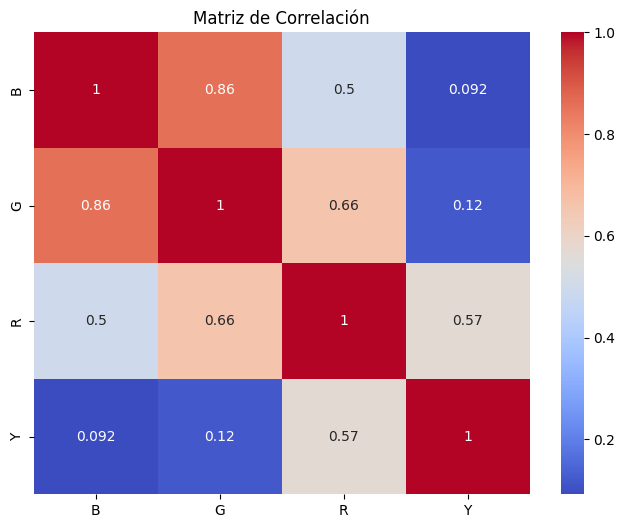

In [15]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

Como ninguna variable superó el umbral, no se eliminó ninguna.

## a) Aplicación de PCA

Se aplica PCA al conjunto obtenido (después de eliminar variables correlacionadas, si se eliminó alguna) para reducir la dimensionalidad.

In [16]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Seleccionar las features restantes (suponiendo que 'y' es la variable objetivo)
features = [col for col in df_Copia.columns if col != 'Y']
X_no_corr = df_Copia[features].values

# Estandarizar las variables antes de aplicar PCA
scaler_pca = StandardScaler()
X_no_corr_scaled = scaler_pca.fit_transform(X_no_corr)

# Aplicar PCA para reducir a 2 componentes
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_no_corr_scaled)

# Crear un nuevo dataframe con las componentes principales y la variable objetivo
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['Y'] = df_Copia['Y'].values
print("Dimensiones con PCA:", df_pca.shape)


Dimensiones con PCA: (245057, 3)


In [17]:
df.shape

(245057, 4)

## b) Entrenamiento y Evaluación del Modelo de Regresión Logística

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def entrenar_evaluar(df_model, features, etiqueta, nombre='Conjunto'):
    # Separar las características (X) y la variable objetivo (y)
    X = df_model[features].values
    y = df_model[etiqueta].values

    # Dividir el dataset en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Entrenar el modelo de regresión logística
    modelo = LogisticRegression(max_iter=1000)
    modelo.fit(X_train, y_train)

    # Predecir y calcular el accuracy
    y_pred = modelo.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{nombre} - Accuracy: {acc:.4f}")
    return acc

# Diccionario para almacenar resultados
resultados = {}

# A) Conjunto Original
resultados['Original'] = entrenar_evaluar(df, ['B', 'G', 'R'], 'Y', 'Original')

# B) Conjunto sin datos faltantes (idéntico al original, pues no hay faltantes)
resultados['Sin faltantes'] = entrenar_evaluar(df_Copia, ['B', 'G', 'R'], 'Y', 'Sin faltantes')

# C) Conjunto sin variables correlacionadas
cols_features = [col for col in df_Copia.columns if col != 'Y']
resultados['Sin correlacionados'] = entrenar_evaluar(df_Copia, cols_features, 'Y', 'Sin correlacionados')

# D) Conjunto con PCA
resultados['PCA'] = entrenar_evaluar(df_pca, ['PC1', 'PC2'], 'Y', 'PCA')


Original - Accuracy: 0.9190
Sin faltantes - Accuracy: 0.9190
Sin correlacionados - Accuracy: 0.9190
PCA - Accuracy: 0.9133


In [51]:
tabla_resultados = pd.DataFrame(list(resultados.items()), columns=['Conjunto', 'Accuracy']).round(4)
print(tabla_resultados)

              Conjunto  Accuracy
0             Original    0.9190
1        Sin faltantes    0.9190
2  Sin correlacionados    0.9190
3                  PCA    0.9133


# 5. Preparación de los datos transformando a ***Y*** en binario

 ## a) Transformación Binaria

In [20]:
df['Y']

,Y
0,1
1,1
2,1
3,1
4,1
...,...
245052,2
245053,2
245054,2
245055,2


In [21]:
df['Y'][df['Y']==1]=0
df['Y'][df['Y']==2]=1

# Verificamos que el cambio se realizó correctamente
df['Y']

,Y
0,0
1,0
2,0
3,0
4,0
...,...
245052,1
245053,1
245054,1
245055,1


## b) Balanceo del modelo

Miraremos la proporción de los datos y la distribución de la variable objetivo **Y**

In [22]:
# Distribución de la variable objetivo
class_distribution = df['Y'].value_counts()
print("Distribución de clases en la variable objetivo:")
print(class_distribution)

class_percentage = df['Y'].value_counts(normalize=True) * 100
print("\nPorcentaje de clases en la variable objetivo:")
for index, value in class_percentage.items():
    print(f"{index}: {value:.2f} %")

Distribución de clases en la variable objetivo:
Y
1    194198
0     50859
Name: count, dtype: int64

Porcentaje de clases en la variable objetivo:
1: 79.25 %
0: 20.75 %


## c) Creación del Modelo

### Extraer features

In [23]:
X = df[['B', 'G', 'R']].values
y = df['Y'].values

# Estandarizar las variables para mejorar la detección de outliers
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Usar KNN de pyod para detectar outliers
knn = KNN()  # Puedes ajustar los parámetros según el comportamiento de tus datos
knn.fit(X_scaled)
# En pyod, los outliers se etiquetan como 1 y los inliers como 0
labels = knn.labels_


In [24]:
# Datos de entrenamiento y prueba:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=57)

# Modelo de regresión logística
model = LogisticRegression(max_iter=1000, class_weight='balanced') # Se balancea el modelo

# Entrenar modelo
model.fit(X_train, y_train)

# Predecir en conjunto de prueba
y_pred = model.predict(X_test)

## d) Evaluación del Modelo

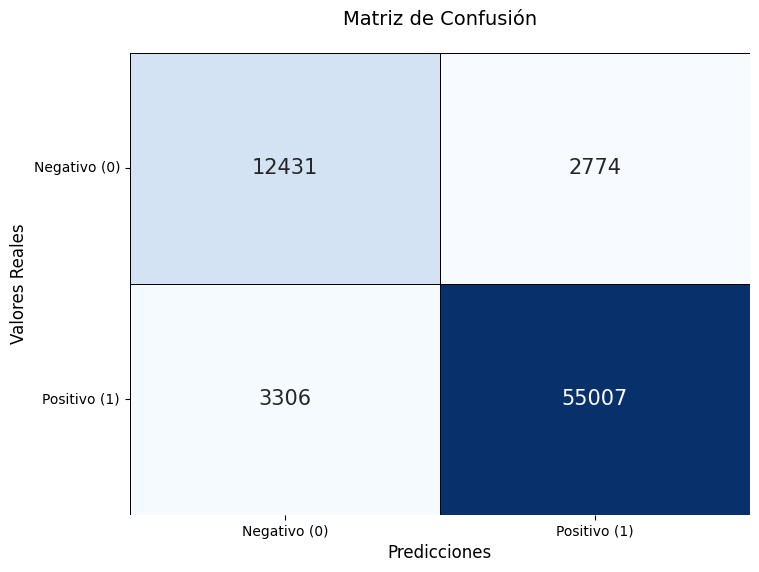


Reporte de Clasificación:

Accuracy: 0.92
Precision: 0.95
Sensitivity (Recall): 0.94
Specificity: 0.82
F1-score: 0.95

              precision    recall  f1-score   support

     Clase 0       0.79      0.82      0.80     15205
     Clase 1       0.95      0.94      0.95     58313

    accuracy                           0.92     73518
   macro avg       0.87      0.88      0.88     73518
weighted avg       0.92      0.92      0.92     73518




In [53]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)


# Crear visualización mejorada
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix,
            annot=True,
            fmt='d',
            cmap='Blues',
            cbar=False,
            annot_kws={'size': 15},
            linewidths=0.5,
            linecolor='black')

# Personalizar ejes y título
plt.title('Matriz de Confusión', fontsize=14, pad=20)
plt.xlabel('Predicciones', fontsize=12)
plt.ylabel('Valores Reales', fontsize=12)
plt.xticks([0.5, 1.5], ['Negativo (0)', 'Positivo (1)'], rotation=0)
plt.yticks([0.5, 1.5], ['Negativo (0)', 'Positivo (1)'], rotation=0)
plt.show()

# Accuracy
accuracy = accuracy_score(y_test, y_pred)

# Precision
precision = precision_score(y_test, y_pred)

# Sensitivity (Recall)
sensitivity = recall_score(y_test, y_pred)

# Specificity
tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp)

# F1-score
f1 = f1_score(y_test, y_pred)


# Mostrar métricas adicionales
print("\nReporte de Clasificación:\n")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Sensitivity (Recall): {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"F1-score: {f1:.2f}")

print("\n" + "="*55)
print(classification_report(y_test, y_pred, target_names=['Clase 0', 'Clase 1']))
print("="*55 + "\n")


## e) Modelo con N-FOLDS

Configuramos el esquema de validación cruzada con N=10, en donde dividimos al conjunto en 10 partes, donde se entrena el modelo 9 veces con diferentes combinaciones y se evalúa en la partición restante

In [40]:
kf = KFold(n_splits=10, shuffle=True, random_state=57)

# Listas para almacenar las métricas de cada iteración
accuracies = []
sensitivities = []
specificities = []
precisions = []
f1_scores = []

conf_matrix_accumulated = np.zeros((2, 2))

# Validación cruzada
for train_index, test_index in kf.split(X): # 10 Iteraciones

    # Dividir Datos de entrenamiento y prueba
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Modelo de regresión logística
    model = LogisticRegression(max_iter=1000)

    # Entrenar modelo
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Métricas
    accuracies.append(accuracy_score(y_test, y_pred))
    sensitivities.append(recall_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificities.append(tn / (tn + fp))

    #conf_matrix = confusion_matrix(y_test, y_pred)
    #print("Matriz de Confusión:")
    #print(conf_matrix)

    #print(f"Accuracy: {accuracy:.4f}")
    #print(f"Sensitivity (Recall): {sensitivity:.4f}")
    #print(f"Specificity: {specificity:.4f}")
    #print(f"Precision: {precision:.4f}")
    #print(f"F1-score: {f1:.4f}")

    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrix_accumulated += conf_matrix

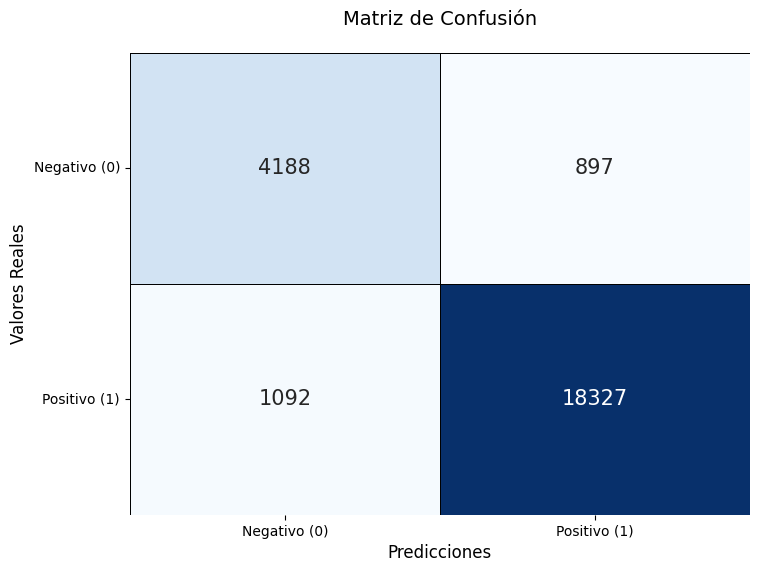


Métricas promedio en N-Folds Validation (N=10):

Accuracy: 0.919
Sensitivity (Recall): 0.944
Specificity: 0.824
Precision: 0.953
F1-score: 0.949

              precision    recall  f1-score   support

     Clase 0       0.80      0.83      0.81      5076
     Clase 1       0.95      0.94      0.95     19429

    accuracy                           0.92     24505
   macro avg       0.88      0.89      0.88     24505
weighted avg       0.92      0.92      0.92     24505



In [41]:
conf_matrix_avg = np.round(conf_matrix_accumulated / 10).astype(int)
#print("\nMatriz de Confusión Promedio:")
#print(conf_matrix_avg)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_avg,
            annot=True,
            fmt='d',
            cmap='Blues',
            cbar=False,
            annot_kws={'size': 15},
            linewidths=0.5,
            linecolor='black')

# Personalizar ejes y título
plt.title('Matriz de Confusión', fontsize=14, pad=20)
plt.xlabel('Predicciones', fontsize=12)
plt.ylabel('Valores Reales', fontsize=12)
plt.xticks([0.5, 1.5], ['Negativo (0)', 'Positivo (1)'], rotation=0)
plt.yticks([0.5, 1.5], ['Negativo (0)', 'Positivo (1)'], rotation=0)
plt.show()


print("\nMétricas promedio en N-Folds Validation (N=10):")
print("\n" + "="*55)
print(f"Accuracy: {np.mean(accuracies):.3f}")
print(f"Sensitivity (Recall): {np.mean(sensitivities):.3f}")
print(f"Specificity: {np.mean(specificities):.3f}")
print(f"Precision: {np.mean(precisions):.3f}")
print(f"F1-score: {np.mean(f1_scores):.3f}")
print("="*55 + "\n")

# Add this line:
print(classification_report(y_test, y_pred, target_names=['Clase 0', 'Clase 1']))

## f) Modelo con Sub-Sampling (10 veces)

In [45]:
# Listas para almacenar las métricas de cada iteración
accuracies_rs = []
sensitivities_rs = []
specificities_rs = []
precisions_rs = []
f1_scores_rs = []

conf_matrix_accumulated = np.zeros((2, 2))

# Repetir el random subsampling 10 veces
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Calcular métricas
    accuracies_rs.append(accuracy_score(y_test, y_pred))
    sensitivities_rs.append(recall_score(y_test, y_pred))
    precisions_rs.append(precision_score(y_test, y_pred))
    f1_scores_rs.append(f1_score(y_test, y_pred))

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificities_rs.append(tn / (tn + fp))

    #print(f"Accuracy: {accuracy:.4f}")
    #print(f"Sensitivity (Recall): {sensitivity:.4f}")
    #print(f"Specificity: {specificity:.4f}")
    #print(f"Precision: {precision:.4f}")
    #print(f"F1-score: {f1:.4f}")

    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrix_accumulated += conf_matrix


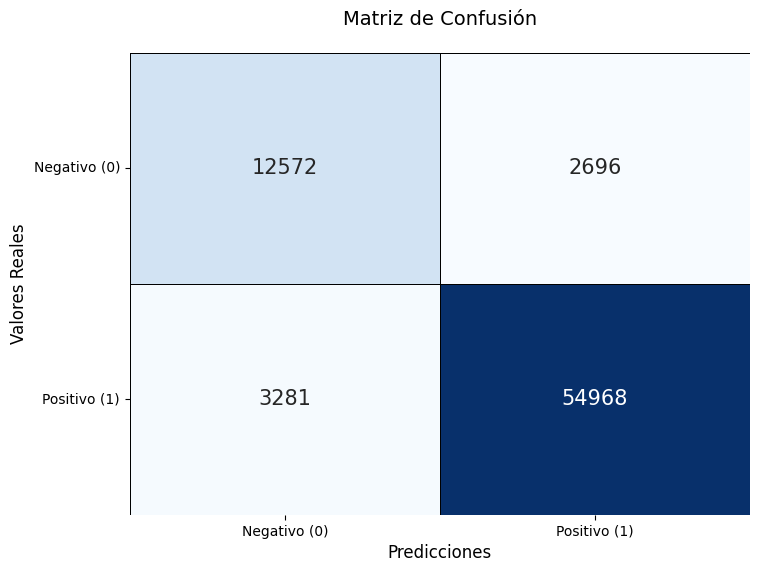


Métricas promedio en Random Subsampling (10 repeticiones):

Accuracy: 0.9187
Sensitivity (Recall): 0.9437
Specificity: 0.8234
Precision: 0.9532
F1-score: 0.9484
F1-score: 0.949



In [49]:
conf_matrix_avg = np.round(conf_matrix_accumulated / 10).astype(int)
#print("\nMatriz de Confusión Promedio:")
#print(conf_matrix_avg)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_avg,
            annot=True,
            fmt='d',
            cmap='Blues',
            cbar=False,
            annot_kws={'size': 15},
            linewidths=0.5,
            linecolor='black')


# Personalizar ejes y título
plt.title('Matriz de Confusión', fontsize=14, pad=20)
plt.xlabel('Predicciones', fontsize=12)
plt.ylabel('Valores Reales', fontsize=12)
plt.xticks([0.5, 1.5], ['Negativo (0)', 'Positivo (1)'], rotation=0)
plt.yticks([0.5, 1.5], ['Negativo (0)', 'Positivo (1)'], rotation=0)
plt.show()

print("\nMétricas promedio en Random Subsampling (10 repeticiones):")
print("\n" + "="*55)
print(f"Accuracy: {np.mean(accuracies_rs):.4f}")
print(f"Sensitivity (Recall): {np.mean(sensitivities_rs):.4f}")
print(f"Specificity: {np.mean(specificities_rs):.4f}")
print(f"Precision: {np.mean(precisions_rs):.4f}")
print(f"F1-score: {np.mean(f1_scores_rs):.4f}")
print(f"F1-score: {np.mean(f1_scores):.3f}")
print("="*55 + "\n")


# **Conclusiones Combinadas**

1. **Rendimiento del Modelo:**
La Regresión Logística aplicada para la segmentación de piel demostró ser un modelo adecuado para la tarea, alcanzando un accuracy de aproximadamente 91.90% en el conjunto original, sin datos faltantes ni eliminación de variables correlacionadas. Además, se observaron altos valores en métricas clave como recall, especificidad, precisión y F1-score, lo que indica que el modelo identifica correctamente la mayoría de los casos positivos y negativos. La consistencia en estos indicadores sugiere que el modelo tiene una buena capacidad de generalización, siendo capaz de mantener un rendimiento robusto frente a distintas divisiones de datos, como la validación cruzada y el submuestreo aleatorio.

2. **Impacto de las Técnicas de Preprocesamiento y PCA:**
El análisis comparativo mostró que la transformación de datos —ya sea eliminando variables con alta correlación (aunque en este caso, la correlación moderada entre B, G y R no justificó la eliminación de ninguna variable) o trabajando con el conjunto original— no generó diferencias significativas en el desempeño del modelo. En contraste, la aplicación de PCA para reducir la dimensionalidad a dos componentes principales resultó en una ligera disminución del accuracy (de 91.90% a 91.33%). Esto sugiere que las tres características originales capturan de manera suficiente la información relevante para la segmentación de piel, y que la reducción de dimensionalidad, si bien puede simplificar el modelo, podría eliminar información crucial.

3. **Robustez y Consistencia:**
La estabilidad en los resultados obtenidos a través de distintas metodologías (sub-sampling, validación cruzada y repeticiones) demuestra la robustez del modelo. Los métodos basados en sub-sampling y N-FOLDS, aunque presentan ligeras variaciones —por ejemplo, un mayor recall en algunos casos y una especificidad algo inferior en otros— confirman que el modelo es consistente y confiable en distintos escenarios de entrenamiento y prueba.

4. **Consideraciones Adicionales:**

- **Desequilibrio de Clases:** Aunque en este estudio el análisis indicó que la transformación de la variable objetivo y las medidas adoptadas fueron suficientes, se recomienda un análisis más profundo en contextos donde el desequilibrio de clases pueda ser más marcado.
Valores Atípicos: En este caso particular no se detectaron datos atípicos, por lo que su impacto no fue evaluado. Sin embargo, en otros escenarios, la presencia de outliers podría afectar el rendimiento del modelo y requerir técnicas de manejo específicas.
- Contexto de Aplicación: Es importante resaltar que la “precisión razonable” alcanzada debe interpretarse en función del contexto en el que se aplique el modelo. Dependiendo de la criticidad de falsos positivos o negativos, podría ser necesario optimizar aún más el modelo o explorar otros enfoques.

## **Conclusión General:**
En síntesis, la Regresión Logística ha demostrado ser una estrategia efectiva para la segmentación de piel, mostrando un rendimiento sólido y consistente. La utilización de las variables originales ***(B, G, R)*** es la opción óptima en este caso, ya que ni la eliminación de variables correlacionadas ni la reducción de dimensionalidad mediante PCA aportaron mejoras sustanciales, e incluso en el caso de PCA se produjo una leve pérdida en el ***Accuracy***.